# Basic Neural Network

## Imports

In [18]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation

In [47]:
data = pd.read_csv('../../data/iris.csv')
data_for_plotting = data.copy()

def determine_target(species):
    if species == 'setosa':
        return 0
    
    if species == 'virginica':
        return 1
    
    if species == 'versicolor':
        return 2

data_for_plotting['target'] = data_for_plotting['species'].apply(determine_target)
data['target'] = data['species'].apply(determine_target)
label = data['target']
data.drop('species', axis=1, inplace=True)
data.drop('target', axis=1, inplace=True)
iris_data = TensorDataset(torch.FloatTensor(data.values), torch.LongTensor(label.values))
iris_loader = DataLoader(iris_data, batch_size=50, shuffle=True)

In [20]:
# Alternatively Sklearn.
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data.values, label.values, test_size=0.2, random_state=33)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## Model

In [22]:
class Model(nn.Module):
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        super().__init__()
        
        # Create layers.
        self.fully_connected_1 = nn.Linear(in_features=in_features, out_features=h1)
        self.fully_connected_2 = nn.Linear(in_features=h1, out_features=h2)
        self.out = nn.Linear(in_features=h2, out_features=out_features)
    
    def forward(self, first_layer_z):
        activated_first_layer_out = F.relu(self.fully_connected_1(first_layer_z))
        activated_second_layer_out = F.relu(self.fully_connected_2(activated_first_layer_out))
        activated_out = self.out(activated_second_layer_out)
        
        return activated_out

## Instantiate the Model, Choose an Optimizer & Error Function

In [23]:
# To fix random initial parameters.
torch.manual_seed(32)
model = Model()

In [24]:
error_function = nn.CrossEntropyLoss() # Because we have a multiclass classification problem.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # If the error stops going down after say 10 epochs, we can add an additional decimal point to the learning rate to take smaller steps.

## Train the Model

In [25]:
# How many runs through all the data?
epochs = 100 # Start small and plot the loss function.
losses = list() # Allows for keeping track of losses.

for i in range(epochs):
    # Run forward & get a prediction.
    y_pred = model.forward(X_train)
    
    # Measure loss / error.
    loss = error_function(y_pred, y_train)
    losses.append(loss)
    
    if i % 10 == 0:
        print(f'Epoch: {i}, Loss: {loss}')
        
    # Back propagation.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0, Loss: 1.1518166065216064
Epoch: 10, Loss: 0.9080570340156555
Epoch: 20, Loss: 0.7041409611701965
Epoch: 30, Loss: 0.5346686244010925
Epoch: 40, Loss: 0.41996076703071594
Epoch: 50, Loss: 0.32500120997428894
Epoch: 60, Loss: 0.21382205188274384
Epoch: 70, Loss: 0.1274299919605255
Epoch: 80, Loss: 0.08812031149864197
Epoch: 90, Loss: 0.07331125438213348


Text(0.5, 0, 'Epoch')

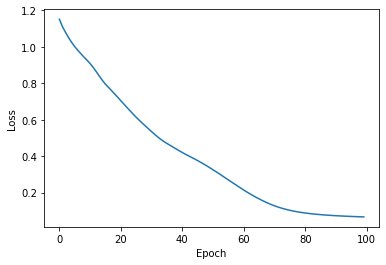

In [29]:
plt.plot(range(epochs), [float(l) for l in losses])
plt.ylabel('Loss')
plt.xlabel('Epoch')

## Validate the Model

In [34]:
with torch.no_grad(): # Don't worry about back propagation / deactivate auto-gradient engine.
    y_val = model.forward(X_test)
    loss = error_function(y_val, y_test)
    
print(float(loss))

0.05847649648785591


In [38]:
correct = 0

with torch.no_grad(): # Don't worry about back propagation / deactivate auto-gradient engine.
    for i, data in enumerate(X_test):
        y_val = model.forward(data)
    
        print(f'{i+1}) {str(y_val)} -> Expected Class: {y_test[i]}')
        
        # If the INDEX of the highest value is equal to the classification index, it was a correct prediction. 
        if y_val.argmax().item() == y_test[i]:
            correct = correct + 1
            
print(f'{correct}/{len(y_test)} Correct Predictions.')

1) tensor([-1.9408, -0.2150,  5.3099]) -> Expected Class: 2
2) tensor([-2.0333, -0.4881,  5.8899]) -> Expected Class: 2
3) tensor([ 3.4886, -3.5997, -2.5672]) -> Expected Class: 0
4) tensor([-3.2179,  1.8041,  5.2268]) -> Expected Class: 2
5) tensor([-5.2637,  6.1273,  3.5717]) -> Expected Class: 1
6) tensor([-7.7095, 11.1907,  1.6848]) -> Expected Class: 1
7) tensor([ 3.4328, -3.5970, -2.4502]) -> Expected Class: 0
8) tensor([ 3.9352, -3.9322, -3.1625]) -> Expected Class: 0
9) tensor([-5.1526,  5.7892,  3.7911]) -> Expected Class: 1
10) tensor([-6.6291,  8.5917,  3.0093]) -> Expected Class: 1
11) tensor([-7.0213,  9.4367,  2.6690]) -> Expected Class: 1
12) tensor([ 3.5310, -3.5598, -2.7022]) -> Expected Class: 0
13) tensor([-6.5006,  8.7306,  2.5416]) -> Expected Class: 1
14) tensor([-3.0192,  1.6088,  5.0832]) -> Expected Class: 2
15) tensor([-5.7371,  6.8346,  3.5529]) -> Expected Class: 1
16) tensor([-1.9871, -0.4709,  5.7686]) -> Expected Class: 2
17) tensor([-4.1892,  4.1490,  4.

## Save / Load the Trained Model

In [39]:
torch.save(model.state_dict(), '../../data/iris_model.pt')

In [41]:
loaded_model = Model()
loaded_model.load_state_dict(torch.load('../../data/iris_model.pt'))

loaded_model.eval()

Model(
  (fully_connected_1): Linear(in_features=4, out_features=8, bias=True)
  (fully_connected_2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

## Make a Prediction

In [43]:
# Create a tensor to represent the parameters for the flower we'd like to predict.
some_flower = torch.tensor([5.6, 3.7, 2.2, 0.5])

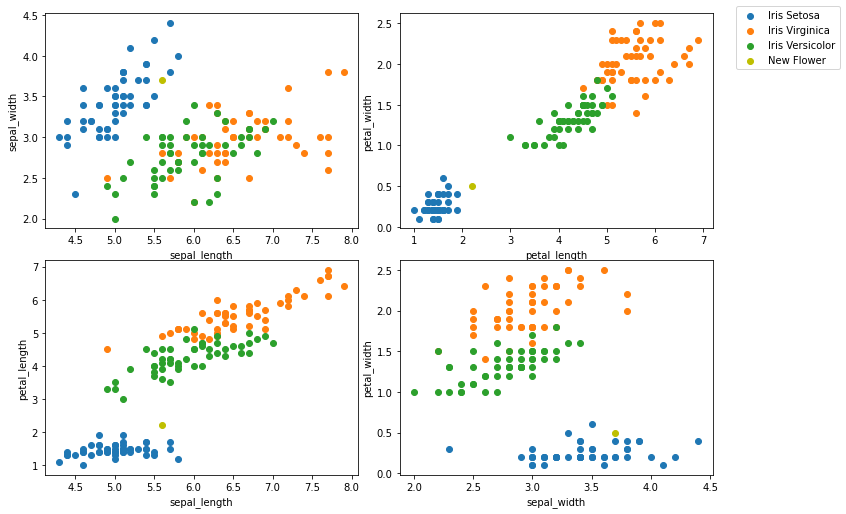

In [56]:
# Plot the new flower to intuitively see what group it belongs to (Iris Setosa)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1), (2,3), (0,2), (1,3)]
labels = ['Iris Setosa', 'Iris Virginica', 'Iris Versicolor', 'New Flower']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = data_for_plotting.columns[plots[i][0]]
        y = data_for_plotting.columns[plots[i][1]]
        ax.scatter(data_for_plotting[data_for_plotting['target'] == j][x], data_for_plotting[data_for_plotting['target'] == j][y])
        ax.set(xlabel=x, ylabel=y)
    
    ax.scatter(some_flower[plots[i][0]], some_flower[plots[i][1]], color='y')

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1., .85))
plt.show()

In [58]:
with torch.no_grad():
    prediction = loaded_model.forward(some_flower)
    predicted_target_index = prediction.argmax().item()

    print(f'Predicted Species: {labels[predicted_target_index]}')

Predicted Species: Iris Setosa
